In [1]:
import os
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= "whitegrid" )
import numpy as np


In [18]:
sns.set_theme(style='white')

In [4]:
df_velocities = pd.read_csv('post_stability/average_velocities.csv')

In [5]:
# Participants 22 , 66, 75, 81 aborted the experiment, hence they will be excluded from the analysis
df_velocities =df_velocities[df_velocities['id'] != 22]
df_velocities =df_velocities[df_velocities['id'] != 66]
df_velocities =df_velocities[df_velocities['id'] != 75]
df_velocities =df_velocities[df_velocities['id'] != 81]

print(f'Resulting number of transcriptions: {df_velocities.shape[0]}')

Resulting number of transcriptions: 825


In [6]:
#The code to check the assumptions was provided by zora-no https://github.com/zora-no
def check_assumptions(df, dv, dv_name):
    '''
    Checks the assumptions of a mixed ANOVA.

    df (pd.DataFrame)
    dv (str): dependent variable column name
    dv_name (str): name of the dependent variable (to be printed)
    '''

    print("Checking the assumptions for the dependent variable {}...\n".format(dv_name))
    all_assumptions = []

    # Assumption of the residuals being normally distributed
    df['factor_comb'] = df["condition"] + '-'+ df["mode"]
    normal = pg.normality(data=df, dv=dv, group='factor_comb')
    if normal["normal"].all():
        print("The residuals are approximately normally distributed for each level of the within-subjects factor (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(True)
    else:
        print("The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(False)

    print()
    # Assumption of homoscedasticity
    print("There should be equal variance for every level of within-subject factor:")
    hybrid = df[df["mode"]=="hybrid"].reset_index(drop=True)
    homo_hybrid = pg.homoscedasticity(data=hybrid, dv=dv, group='condition')
    all_assumptions.append(homo_hybrid["equal_var"][0])
    print("For the level hybrid, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_hybrid["pval"][0].round(3), homo_hybrid["equal_var"][0]))

    fp = df[df["mode"]=="Firstperson"].reset_index(drop=True)
    homo_fp = pg.homoscedasticity(data=fp, dv=dv, group='condition')
    all_assumptions.append(homo_fp["equal_var"][0])
    print("For the level First Person, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_fp["pval"][0].round(3), homo_fp["equal_var"][0]))

    print()
    # Assumption of sphericity
    sphericity = pg.sphericity(data=df, dv=dv, subject='id', within='condition')
    all_assumptions.append(sphericity[0])
    print("Mauchly’s test of sphericity resulted in a p-value of {}, indicating that the assumption is {}.".format(sphericity[-1], sphericity[0]))

    print()
    # Assumption of homogeneity of the variance-covariance matrices:
    print("The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:")
    box_fp = pg.box_m(data=fp, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_fp["equal_cov"][0])
    print("For the level First Person, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_fp["pval"][0].round(3), box_fp["equal_cov"][0]))

    box_hybrid = pg.box_m(data=hybrid, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_hybrid["equal_cov"][0])
    print("For the level hybrid, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_hybrid["pval"][0].round(3), box_hybrid["equal_cov"][0]))

    print()
    # Assumption of no outliers
    #outliers = df[df[dv] > df[dv].mean() + 3 * df[dv].std()]
    outliers = df[np.abs(df[dv] - df[dv].mean()) > (3 * df[dv].std())]
    print("A data point is called an outlier if it > 3 sd away from the mean.")
    if outliers.empty:
        print("There are no outliers!")
        all_assumptions.append(True)
    else:
        print("There are outliers! The outliers are the participants {}".format(outliers["id"].values))
        print(outliers)
        all_assumptions.append(False)


    if all(x == True for x in all_assumptions):
        print()
        print("ALL ASSUMPTIONS ARE TRUE!")

## Postural Stability Test

In [7]:
df_velocities.head()

,id,condition,mode,condition_mode,station,time_frame_begin,time_frame_end,motion_sickness_score,name_of_audio_data,motionsickness_score_rating_begin,motionsickness_score_rating_accepted_timeStamp,average_velocity
0,1,Blob,hybrid,BlobHybrid,1,1.637653e+09,1.637653e+09,0,001_BlobHybrid_1,1.637653e+09,1.637653e+09,0.007961
1,1,Blob,Firstperson,BlobFirstperson,3,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_3,1.637656e+09,1.637656e+09,0.006391
2,1,Blob,Firstperson,BlobFirstperson,1,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_1,1.637656e+09,1.637656e+09,0.006688
3,1,Blob,Firstperson,BlobFirstperson,2,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_2,1.637656e+09,1.637656e+09,0.008408
4,1,Blob,Firstperson,BlobFirstperson,0,1.637655e+09,1.637655e+09,0,001_BlobFirstperson_0,1.637655e+09,1.637655e+09,0.006033


### Visualizations
Before conducting any analysis we will visually explore the data.

#### Data distribution
Below you can find the distribution of the average velocity by condition + mode and, condition alone. As one can easily tell, their distributions do not differ much from each other.

In [29]:
df_velocities.mode = df_velocities.replace({'hybrid' : 'Hybrid', 'Firstperson' : 'First-person'}, inplace=True)
df_velocities

,id,condition,mode,condition_mode,station,time_frame_begin,time_frame_end,motion_sickness_score,name_of_audio_data,motionsickness_score_rating_begin,motionsickness_score_rating_accepted_timeStamp,average_velocity,factor_comb
0,1,Blob,Hybrid,BlobHybrid,1,1.637653e+09,1.637653e+09,0,001_BlobHybrid_1,1.637653e+09,1.637653e+09,0.007961,Blob-hybrid
1,1,Blob,First-person,BlobFirstperson,3,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_3,1.637656e+09,1.637656e+09,0.006391,Blob-Firstperson
2,1,Blob,First-person,BlobFirstperson,1,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_1,1.637656e+09,1.637656e+09,0.006688,Blob-Firstperson
3,1,Blob,First-person,BlobFirstperson,2,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_2,1.637656e+09,1.637656e+09,0.008408,Blob-Firstperson
4,1,Blob,First-person,BlobFirstperson,0,1.637655e+09,1.637655e+09,0,001_BlobFirstperson_0,1.637655e+09,1.637655e+09,0.006033,Blob-Firstperson
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,87,Blob,Hybrid,BlobHybrid,1,1.644591e+09,1.644591e+09,0,087_BlobHybrid_1,1.644591e+09,1.644591e+09,0.010170,Blob-hybrid
836,87,Blob,First-person,BlobFirstperson,3,1.644589e+09,1.644589e+09,1,087_BlobFirstperson_3,1.644589e+09,1.644589e+09,0.009525,Blob-Firstperson
837,87,Blob,First-person,BlobFirstperson,1,1.644588e+09,1.644588e+09,1,087_BlobFirstperson_1,1.644588e+09,1.644588e+09,0.007187,Blob-Firstperson
838,87,Blob,First-person,BlobFirstperson,0,1.644588e+09,1.644588e+09,0,087_BlobFirstperson_0,1.644588e+09,1.644588e+09,0.007492,Blob-Firstperson


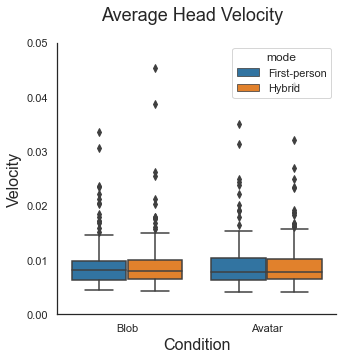

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
sns.boxplot(data=df_velocities,
            x='condition',
            y='average_velocity',
            hue='mode',
            hue_order=['First-person', 'Hybrid']
            )


sns.despine()
ax.set_xlabel('Condition', size=16)
ax.set_ylabel('Velocity', size=16)
ax.set_ylim(0,0.05)
plt.suptitle('Average Head Velocity', size=18)

plt.show()

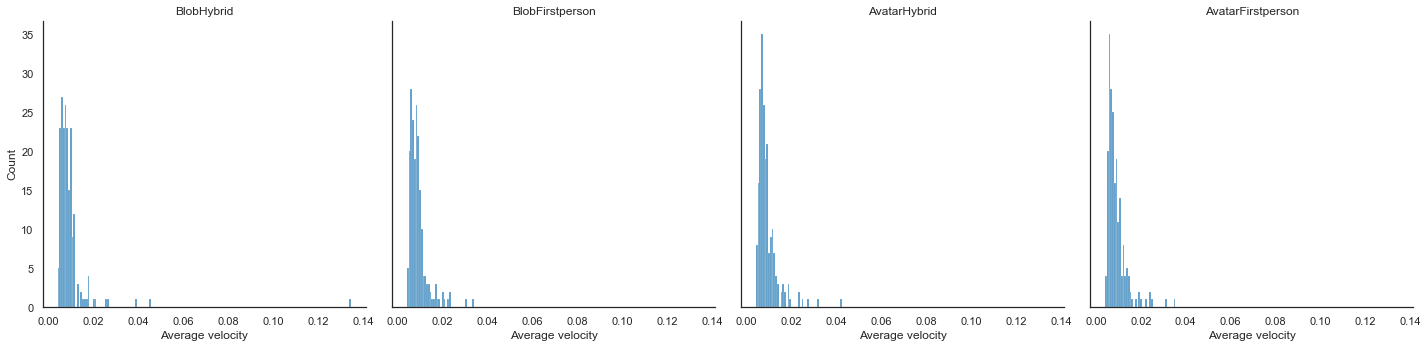

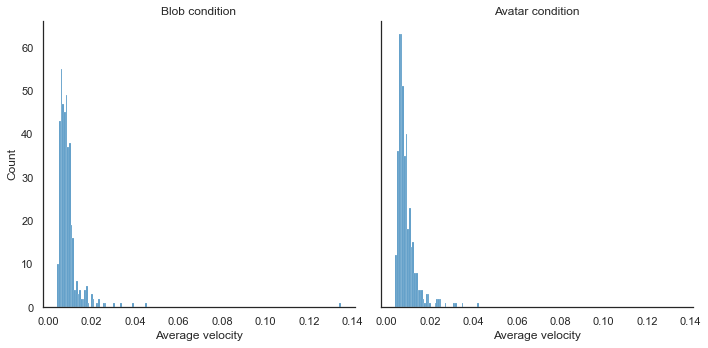

In [22]:
g= sns.displot(df_velocities, x="average_velocity", col='condition_mode',palette="tab10")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels('Average velocity', 'Count')
t =sns.displot(df_velocities, x="average_velocity",col ='condition',palette="tab10")
t.set_titles(col_template="{col_name} condition", row_template="{row_name}")
t.set_axis_labels('Average velocity', 'Count')
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

The average velocity tends to 0, as it is shown above. On ther hand, if we observe the distribution of the motion sickness scores (below) we can see that it is skewed to the left: most participants said not to have been motion sick. The average velocity, as long as it is a measurement of sickness, seems to back up the motion sickness scores obtained.

<AxesSubplot:title={'center':'Motion Sickness Score'}, ylabel='Frequency'>

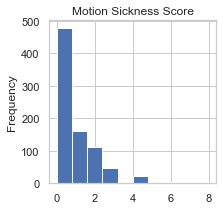

In [9]:
df_velocities['motion_sickness_score'].plot(kind ='hist', title='Motion Sickness Score', figsize=(3,3))

#### Boxplot
As the two boxplot below show, the data contain several outliers.

<AxesSubplot:xlabel='station', ylabel='average_velocity'>

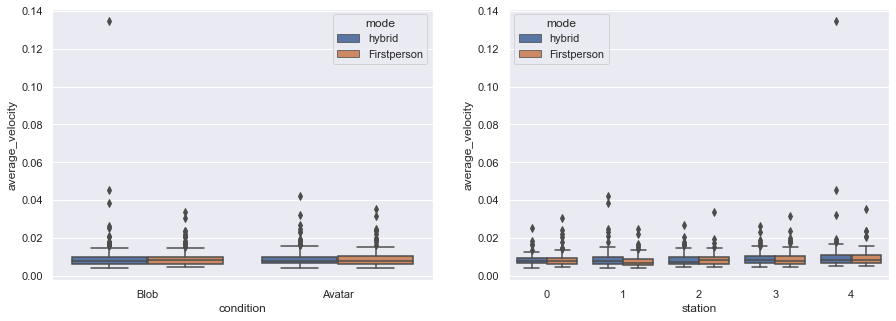

In [10]:
sns.set(rc = {'figure.figsize':(5,4)})
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
sns.boxplot(x='condition', y='average_velocity', hue='mode', data=df_velocities, ax=ax1)
ax2 = fig.add_subplot(122)
sns.boxplot(x='station', y='average_velocity', hue='mode', data=df_velocities,ax=ax2)

#### Pointplot
Below we can observe the interaction between the levels of the independet variables.

<AxesSubplot:xlabel='mode', ylabel='average_velocity'>

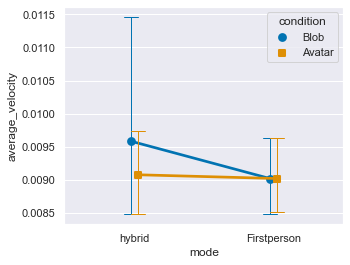

In [11]:
sns.pointplot(data=df_velocities, x='mode', y='average_velocity', hue='condition', dodge=True, markers=['o', 's'],
	      capsize=.1, errwidth=1, palette='colorblind')

### Descriptive Statistics

In [12]:
df_velocities.groupby(['condition']).describe()['average_velocity']

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
Avatar,420.0,0.009049,0.004487,0.004114,0.006405,0.007783,0.010214,0.042035
Blob,405.0,0.009306,0.007691,0.004218,0.006391,0.008077,0.009959,0.134691


### Mixed ANOVA

#### Description of the analysis

- Between subject variable (factor): Condition (Avatar, Blob) each subject is assigned only once to treatment.
- Within subject: subject assigned both treatments (Hybrid, Firstperson)
- Dependent variable: average_velocity

In [13]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='average_velocity', within='mode', between='condition', subject='id', data=df_velocities)
# printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
condition    0.000      1     80  0.000  0.083    0.774  0.001  nan
mode         0.000      1     80  0.000  0.762    0.385  0.009    1.000
Interaction  0.000      1     80  0.000  0.540    0.464  0.007  nan



At a significance level 0.05, we can say that there is no significant interaction effect. The effect of the condition/treatment on the average velocity (dependent variable) does not depend on the mode or perspective (Hybrid/Firstperson). Hence, whether someone is motion sick (high velocity) or not (low velocity) does not depend on the perspective used to navigate the VR environment.

#### Assumption check

In [14]:
check_assumptions(df_velocities,'average_velocity', 'average_velocity')

Checking the assumptions for the dependent variable average_velocity...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level hybrid, Levene's test resulted in a p-value of 0.499, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.694, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.744, indicating that the assumption is True.
For the level hybrid, Box’s M test resulted in a p-value of 0.0, indicating that the assumpt